In [1]:
import numpy as np
import pandas as pd
from os.path import join

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

from Bio import SeqIO
from Bio import AlignIO

import protein_feature_calculations as pfc

import my_callbacks
from pkg_resources import resource_stream, resource_filename, resource_exists
import seaborn as sns; sns.set_theme(color_codes=True)

ALANINE = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # sets global vareable ALANINE as a one hot representation of alanine
NOTHING = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # sets global vareable NOTHING as a one hot representation that's empty


Using TensorFlow backend.


In [2]:
class DeepETInference(object):
    '''
    A class for getting DeepET embeddings.
    '''
    def __init__(self, model, layer):

        # load the model
        assert model in ['ogt', 'topt']
        self.model_type = model

        if model == 'ogt':
            model_path = resource_filename(__name__, "best_ogt_model")
            self.model = load_model(join(model_path, 'bestmodel.h5'), custom_objects={'coef_det_k':my_callbacks.coef_det_k})

        elif model == 'topt':
            model_path = resource_filename(__name__, "best_topt_model")
            self.model = load_model(join(model_path, 'bestmodel.h5'), custom_objects={'coef_det_k':my_callbacks.coef_det_k})

        else:
            raise ValueError

#         # make a smaller one to get the embeddings
#         assert layer in ['flatten_1', 'dense_1', 'dense_2']
#         self.layer = layer
#         self.build_bottleneck_model(model=self.model, layer_name=self.layer)


    def run_inference(self, filepath):
        '''
        Accept fasta file path and make predictions for each of these.
        Return data frame.
        '''
        # read sequences into a Pandas series with sequences and identifiers
        seqs = self._series_from_seqio(filepath, 'fasta')
        seqs = seqs.str.rstrip('*')

        # one-hot encoding of sequences
        encoded_seqs = self.seq_to_encoding(seqs)

        # get sequence predictions
        predictions = self.model.predict(encoded_seqs)

        return pd.DataFrame(predictions)


    def get_embeddings(self, filepath):
        '''
        Accept fasta file path and obtain embeddings for each of these.
        Return data frame.
        '''
        # read sequences into a Pandas series with sequences and identifiers
        seqs = self._series_from_seqio(filepath, 'fasta')
        seqs = seqs.str.rstrip('*')

        # one-hot encoding of sequences
        encoded_seqs = self.seq_to_encoding(seqs)

        # get sequence embeddings
        embeddings = self.bottleneck_model.predict(encoded_seqs)

        return pd.DataFrame(embeddings)


    def occlusion_1d_pdb(self, pdb, window, padding=2000):
        '''
        Extract sequence from PDB structure,
        then occlude using a sliding window.
        Return the original predicted temp, temperature
        change and a z-score for each position
        indicating sensititivity.
        '''
        # get seqres from structure
        # here

        # Occlude chain A
        # seq = x['A']
        raise NotImplementedError
        return self.occlusion_1d(seq, window, padding)


    def occlusion_1d(self, seq, window, padding=2000):
        '''
        Occlude a single sequence using a sliding window.
        Return the original predicted temp, temperature
        change and a z-score for each position
        indicating sensititivity.
        '''
        seq = self._to_binary(seq.rstrip('*'))
        size_seq = len(seq)

        # first predict the unchanged sequence
        original_seq = self._zero_padding(seq, padding)
        wt_pred = self.model.predict( original_seq.reshape([1, original_seq.shape[0], original_seq.shape[1]]) )[0]

        seqs = []
        for i in range(0, size_seq - window):

            # create empty array same shape as the one-hot sequence
            tmp = np.zeros((seq.shape[0], seq.shape[1]))

            # one-dimensional vector to index which amino acids to replace
            logic = np.zeros(seq.shape[0], dtype = bool)
            logic[i:i+window] = True

            # do the replacement
            tmp[logic,:] = NOTHING
            tmp[~logic,:] = seq[~logic,:]

            # pad sequence to full length
            tmp = self._zero_padding(tmp, padding)
            seqs.append(tmp)

        seqs = np.array(seqs)

        # predict for the occluded sequences
        predictions = self.model.predict(seqs)

        # compute the average prediction for each position
        window_average = np.convolve(predictions.reshape(-1), np.ones(window)/window, mode='valid')

        # compute the change in temperature, as a fraction of the WT prediction
        change = (wt_pred - window_average) / wt_pred

        # compute a z-score
        z_score = (change-np.mean(change))/np.std(change)

        return wt_pred, change, z_score


    def occlusion_3d(self, pdb, radius, padding=2000):
        '''
        Using a protein structure (PDB format), for each
        position occlude all residues that it is within
        a certain radius of (excluding neighboring residues).
        Return the original predicted temp, temperature
        change and a z-score for each position
        indicating sensititivity.
        '''
        pass


    def _series_from_seqio(self, fn, format, **kwargs):
        '''
        '''
        if format in SeqIO._FormatToIterator.keys():
            reader = SeqIO.parse
        elif format in AlignIO._FormatToIterator.keys():
            reader = AlignIO.read
        else:
            raise ValueError("format {} not recognized by either SeqIO or AlignIO".format(format))

        if isinstance(fn, str) and 'gz' in fn:
            with gzip.open(fn, "rt") as fh:
                seqs = reader(fh, format, *kwargs)
        else:
            seqs = reader(fn, format, *kwargs)

        seqs = [(r.description, str(r.seq).upper()) for r in seqs]
        seqs = list(zip(*seqs))
        seqs = pd.Series(seqs[1], index=seqs[0], name="seq")

        return seqs


    def build_bottleneck_model(self, model, layer_name):
        '''
        Take full model and truncate at flatten or dense layers
        '''
        for layer in model.layers:
            if layer.name == layer_name:
                output = layer.output
        self.bottleneck_model = Model(model.input, output)



    def print_model(self):
        '''
        Print out the layers of a model
        '''
        print('Layers in base model:')
        for layer in self.bottleneck_model.layers:
            print(layer.name)
        print('')


    def _to_binary(self, seq):
        '''
        Eoncode non-standard amino acids like X as all zeros
        output a array with size of L*20
        '''
        seq = seq.upper()
        aas = 'ACDEFGHIKLMNPQRSTVWY'
        pos = dict()
        for i in range(len(aas)): pos[aas[i]] = i

        binary_code = dict()
        for aa in aas:
            code = np.zeros(20)
            code[pos[aa]] = 1
            binary_code[aa] = code

        seq_coding = np.zeros((len(seq),20))
        for i,aa in enumerate(seq):
            code = binary_code.get(aa,np.zeros(20))
            seq_coding[i,:] = code
        return seq_coding


    def _zero_padding(self, inp, length, start=False):
        '''
        zero pad input one hot matrix to desired length
        start .. boolean if pad start of sequence (True) or end (False)
        '''
        assert len(inp) <= length
        out = np.zeros((length,inp.shape[1]))
        if start:
            out[-inp.shape[0]:] = inp
        else:
            out[0:inp.shape[0]] = inp
        return out


    def seq_to_encoding(self, seqs, length_cutoff = 2000):
        '''
        Process amino acid sequence, preparing it as input to the network.
        '''
        encodings = []
        for seq in seqs:
            encodings.append(self._zero_padding(self._to_binary(seq), length_cutoff))
        return np.array(encodings)

### Initialize the network, get the first layer filters
The "window" is 9 and there are 20 amino acid channels. I concatenate these so that each filter is a 1D vector.

In [3]:
# initialize
deepet = DeepETInference(model='topt', layer='flatten_1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
# get wts
first_filters = deepet.model.layers[1].get_weights()
filter_wts = first_filters[0]
filter_wts.shape

(9, 20, 512)

In [5]:
# concatenate the channels
reshaped_wts = filter_wts.reshape(180, 512)
reshaped_wts.shape

(180, 512)

### Cluster the filter values, to see whether there are any patterns

/home/martin/miniconda3/envs/deepet/lib/python3.6/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


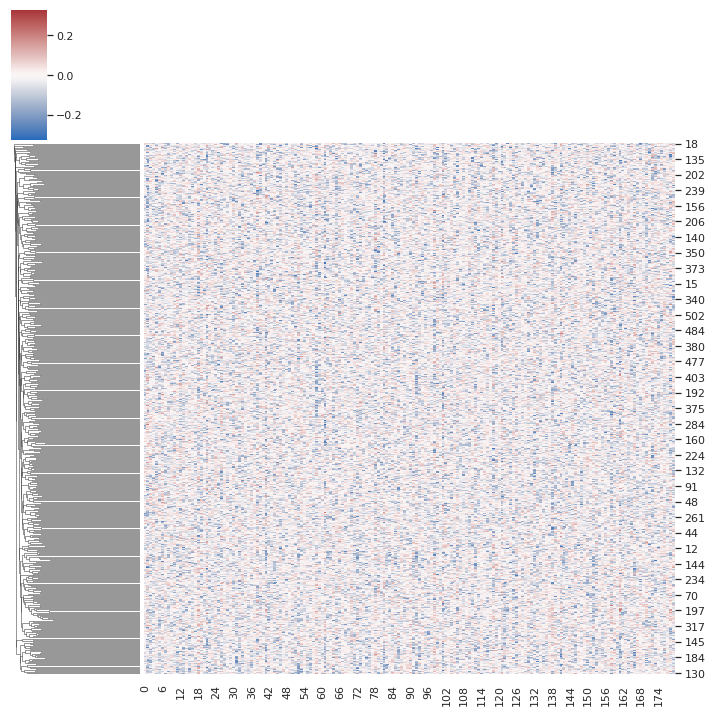

In [6]:
data = reshaped_wts.T

sns.clustermap(data,
               col_cluster=False,
               cmap='vlag',
               vmin=-max(abs(data.min()), data.max()),
               vmax=max(abs(data.min()), data.max()))

### Take a look at the values so that I can more easily set the thresholds

<AxesSubplot:ylabel='Count'>

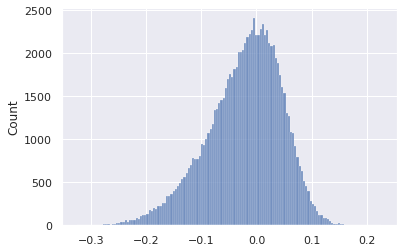

In [7]:
sns.histplot(reshaped_wts.flatten())

### Go through all the channels of all the filters and summarize what the networks is "looking at"
**Note:** I'm assuming that the channels are in the order specified in `aas`, this should be confirmed!

In [8]:
# aas = 'ACDEFGHIKLMNPQRSTVWY'
# all_attn = []

# # for each filter
# for filter_num in range(0, reshaped_wts.shape[1]):
    
#     # due to the thereshold i sometimes end up with "empty" logos, or with only one aa, keep track
#     num_dash = 0
    
#     # create a mask using the threshold
#     mask = ((reshaped_wts.T[filter_num] > 0.1) + \
#             (reshaped_wts.T[filter_num] < -0.2)).reshape(20, 9)

#     # collect the amino acids at each pos
#     attn = []
#     for pos in range(0, 9):
#         res = np.array(list(aas))[mask[:, pos]]

#         if len(res) == 0:
#             attn.append('-')
#             num_dash += 1
            
#         elif len(res) == 1:
#             attn.append(res[0])
            
#         else:
#             attn.append('[{}]'.format('/'.join(res)))
            
#     # save "logo" if it has more than one position with an aa in it
#     if num_dash < 8:
#         all_attn.append(''.join(attn).strip('-'))
        
# sorted(list(set(all_attn)))

In [9]:
# only positive wts

aas = 'ACDEFGHIKLMNPQRSTVWY'
all_attn_pos = []

# for each filter
for filter_num in range(0, reshaped_wts.shape[1]):
    
    # due to the thereshold i sometimes end up with "empty" logos, or with only one aa, keep track
    num_dash = 0
    
    # create a mask using the threshold
    mask = (reshaped_wts.T[filter_num] > 0.1).reshape(20, 9)

    # collect the amino acids at each pos
    attn = []
    for pos in range(0, 9):
        res = np.array(list(aas))[mask[:, pos]]

        if len(res) == 0:
            attn.append('-')
            num_dash += 1
            
        elif len(res) == 1:
            attn.append(res[0])
            
        else:
            attn.append('[{}]'.format('/'.join(res)))
            
    # save "logo" if it has more than one position with an aa in it
    if num_dash < 8:
        all_attn_pos.append(''.join(attn).strip('-'))
        
sorted(list(set(all_attn_pos)))

['A------A',
 'A------M',
 'A------P',
 'A------V',
 'A------[V/W]',
 'A-----I',
 'A----DMW',
 'A----KK',
 'A---A-Y',
 'A---F--V',
 'A---FK',
 'A---FR',
 'A---H--D',
 'A--DQF-Y',
 'A--E',
 'A--Q---[D/T]',
 'A--[C/E]---V',
 'A--[Q/R]-S-V',
 'A-F',
 'A-P-V--W',
 'A-Q--YD',
 'A-[D/V]',
 'AD',
 'AN',
 'AN-Q',
 'AN-Q---M',
 'ANWY--R',
 'AS',
 'AW-S',
 'A[C/G]',
 'A[I/Y]',
 'C-----QT',
 'C---F--[M/W]',
 'C---[K/V]FG',
 'C-F---[R/S]',
 'C-F-YD',
 'CF---[K/N]',
 'CG',
 'CHL-Y',
 'CL',
 'CL-C',
 'CP--G',
 'CQ-P',
 'CVE-R',
 'D------V',
 'D-----A',
 'D-----E',
 'D-----K',
 'D----F',
 'D----F-YV',
 'D----T',
 'D----W',
 'D----[F/W]--V',
 'D---F-A-D',
 'D---H',
 'D---H---V',
 'D---H-F-D',
 'D---W',
 'D--D----D',
 'D--D--V',
 'D--DPL',
 'D--M',
 'D--V-G',
 'D--[C/K]',
 'D-AE[E/F]',
 'D-IY--G',
 'D-P---V-M',
 'D-Q--L-[C/I]W',
 'D-T-H--HK',
 'D-TS---E',
 'D-W-H',
 'D-Y-----W',
 'D-Y----[D/H/T]',
 'DA',
 'DA[A/M]',
 'DC-D--A-[D/V]',
 'DF----[H/K/Q]',
 'DL--I-G',
 'DNY----V',
 'DQN',
 'DS--A--[G/Y]',
 

In [10]:
print(len(all_attn_pos))

376


In [11]:
# only negative wts

aas = 'ACDEFGHIKLMNPQRSTVWY'
all_attn_neg = []

# for each filter
for filter_num in range(0, reshaped_wts.shape[1]):
    
    # due to the thereshold i sometimes end up with "empty" logos, or with only one aa, keep track
    num_dash = 0
    
    # create a mask using the threshold
    mask = (reshaped_wts.T[filter_num] < -0.2).reshape(20, 9)

    # collect the amino acids at each pos
    attn = []
    for pos in range(0, 9):
        res = np.array(list(aas))[mask[:, pos]]

        if len(res) == 0:
            attn.append('-')
            num_dash += 1
            
        elif len(res) == 1:
            attn.append(res[0])
            
        else:
            attn.append('[{}]'.format('/'.join(res)))
            
    # save "logo" if it has more than one position with an aa in it
    if num_dash < 8:
        all_attn_neg.append(''.join(attn).strip('-'))
        
sorted(list(set(all_attn_neg)))

['A-----R',
 'A----F',
 'A----N',
 'A----P',
 'A----ST',
 'A---R',
 'A--E---W',
 'A--W--S',
 'A-D----T',
 'A-E---N',
 'A-W',
 'AF[D/K]----Y',
 'AF[R/S]',
 'AI--R-C',
 'AM-[H/Q]',
 'AN-M',
 'AY',
 'C---D',
 'C---P',
 'C--R[H/Y]',
 'CM',
 'CS-H-N',
 'C[Q/S]',
 'D-----E',
 'D----E',
 'D---HV',
 'D--L---R',
 'D--Q',
 'D--S-V',
 'D--V[H/Y]',
 'D--W',
 'D-FS',
 'D-V',
 'D-[F/N][L/P]-[E/I]',
 'DA--C-GRW',
 'DCK',
 'DM',
 'DW',
 'E---V--W',
 'E---Y',
 'E--D',
 'E-[F/G]',
 'EC',
 'EWK',
 'F-----V',
 'F----P',
 'F----QV',
 'F--Q--P',
 'F-H',
 'F-N-EL--P',
 'F-[Q/R]',
 'FA',
 'FD',
 'FD---E[G/V]',
 'FG--K',
 'FK',
 'FQ----N',
 'G-----R-K',
 'G-----T[H/K]',
 'G----[E/K]',
 'G--W',
 'G--WL',
 'G--Y',
 'G-M',
 'G-M-N',
 'GM-P-N',
 'H------H',
 'H----P',
 'H--H',
 'H--P---N',
 'H--W',
 'H-A',
 'H-F--H',
 'H-K',
 'H-N----Y',
 'H-Q',
 'H-SH',
 'HD',
 'HLR',
 'HM',
 'I-----E',
 'I---C-[P/T]',
 'I--E---KQ',
 'I--Q',
 'I-A',
 'I-Q-A',
 'I-S',
 'IP',
 'IQ---M',
 'I[C/S]--[C/Y]',
 'I[D/Y]---Y',
 'K-------H'

In [12]:
print(len(all_attn_neg))

281
